In [6]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader
from dataloader import OCTSegDataset
import torch
import numpy as np

data_root = "/media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/dataset/cityscapes"  # change to your dataset folder
batch_size = 4
num_classes = 4
crop_size = 512

    # Train dataset
train_dataset = OCTSegDataset(root_dir=data_root, split="train")
# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

def compute_mean_std(dataset):
    loader = DataLoader(train_dataset, batch_size=16, shuffle=False, num_workers=4)
    mean = 0.
    std = 0.
    total_images = 0
    for images, _ in loader:
        # images: [B, 1, H, W]
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)  # flatten HxW
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples
    mean /= total_images
    std /= total_images
    return mean, std

mean, std = compute_mean_std(train_dataset)
print("Computed mean:", mean)
print("Computed std:", std)

Computed mean: tensor([0.0002, 0.0002, 0.0002])
Computed std: tensor([1.0000, 1.0000, 1.0000])


/home/be-light/anaconda3/envs/fusegnet/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16..1.84].


Image shape: (512, 512, 3)
Target shape: torch.Size([512, 512])
Unique classes in target: tensor([0, 1, 2, 3])
Image min/max: 0.0 1.0


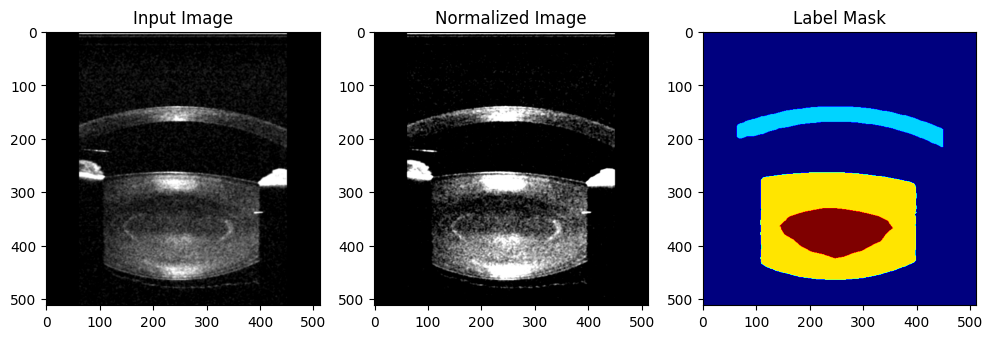

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader
from dataloader import OCTSegDataset
import torch
import numpy as np
# Use your dataset
data_root = "/media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/dataset/cityscapes"  # change to your dataset folder
batch_size = 4
num_classes = 4
crop_size = 512

    # Train dataset
train_dataset = OCTSegDataset(root_dir=data_root, split="train", input_size=(crop_size, crop_size))
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

    # Validation dataset
val_dataset = OCTSegDataset(root_dir=data_root, split="val")
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Pick a sample
image, target = train_loader.dataset[0]  # first image and mask
image = image.permute(1, 2, 0).numpy()  # CHW to HWC
target2 = target.numpy()  # HxW

print("Image shape:", image.shape)
print("Target shape:", target.shape)
print("Unique classes in target:", torch.unique(target))

print("Image min/max:", image.min(), image.max())
# Convert target IDs to colors for visualization
image_norm = (image - 0.08) / 0.5


# p2, p98 = np.percentile(image, (2, 98))
# image_norm = np.clip((image_norm - p2) / (p98 - p2), 0, 1)

# image_norm = (image - image.min()) / (image.max() - image.min())

# Plot
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.title("Input Image")
plt.imshow(image)  # image is PIL, already RGB

plt.subplot(1,3,2)
plt.title("Normalized Image")
plt.imshow(image_norm)

plt.subplot(1,3,3)
plt.title("Label Mask")
plt.imshow(target, cmap='jet', vmin=0, vmax=num_classes-1)  # target is 2D array of class IDs
plt.show()


In [28]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import cv2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_path = "/media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/dataset/cityscapes/images/val/CN038_MM_37_F__OS__6-0D__6__Horizontal_oct.png"   # update path
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

print("Image shape:", img.shape)
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # make it 3-channel
print("Image shape after color conversion:", img.shape)

# Keep copy for visualization
img_vis = img.copy()

# Convert to tensor
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((512, 512)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 3 channels
])

img_tensor2 = transform(img).unsqueeze(0).to(device)  # Add batch dimension
print("Tensor shape:", img_tensor2.shape)


Image shape: (1600, 1600)
Image shape after color conversion: (1600, 1600, 3)
Tensor shape: torch.Size([1, 3, 512, 512])


Tensor shape: torch.Size([1, 3, 512, 512])
Predicted mask shape: (512, 512)
Unique classes in prediction: [0 1 2 3]


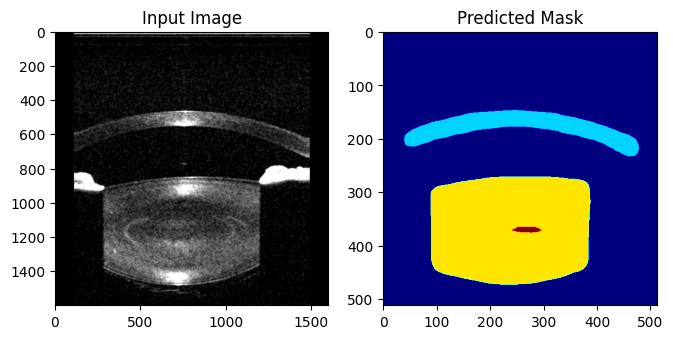

In [7]:
import torch
import torch.nn as nn
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

# -----------------------------
# 1. Device
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# 2. Load image
# -----------------------------
img_path = "/media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/dataset/cityscapes/images/val/CN038_MM_37_F__OS__6-0D__6__Horizontal_oct.png"  # replace with your image path
image = Image.open(img_path).convert("RGB")  # grayscale
# Convert grayscale to RGB
# image = image.convert("RGB")

# Resize to model input size (must match training crop_size)
crop_size = 512
transform = transforms.Compose([
    transforms.Resize((crop_size, crop_size)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    transforms.Normalize(mean=[0.08,0.08,0.08], std=[0.5,0.5,0.5])
])
# img_tensor = transform(image).unsqueeze(0).to(device)  # [1,3,H,W]
img_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
print("Tensor shape:", img_tensor.shape)

# -----------------------------
# 3. Load model
# -----------------------------
num_classes = 4
model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1,1))

# Load checkpoint
checkpoint_path = "checkpoints/deeplabv3_fold5_best.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

# Depending on how you saved the model:
if "model_state" in checkpoint:
    model.load_state_dict(checkpoint["model_state"])
else:
    model.load_state_dict(checkpoint)
    
model.to(device)
model.eval()

# -----------------------------
# 4. Forward pass & prediction
# -----------------------------
with torch.no_grad():
    output = model(img_tensor)['out']       # [1, num_classes, H, W]
    pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # [H,W]
print("Predicted mask shape:", pred.shape)
print("Unique classes in prediction:", np.unique(pred))
# -----------------------------
# 5. Convert class IDs to colors
# -----------------------------
# Define colors same as in OCTDataset
# colors = np.array([
#     [0, 0, 0],        # background
#     [42, 125, 209],   # cornea
#     [255, 204, 51],   # lens
#     [250, 50, 83]     # nucleus
# ], dtype=np.uint8)

# mask_color = colors[pred]

# -----------------------------
# 6. Visualization
# -----------------------------
# Plot
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.title("Input Image")
plt.imshow(image)  # image is PIL, already RGB

plt.subplot(1,3,2)
plt.title("Predicted Mask")
plt.imshow(pred, cmap='jet', vmin=0, vmax=num_classes-1)  

plt.show()


Sample 1: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


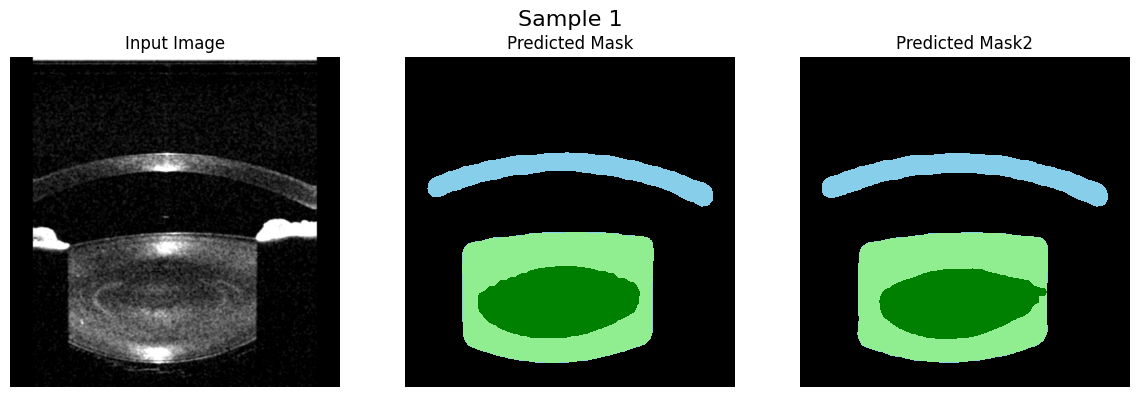

Sample 2: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


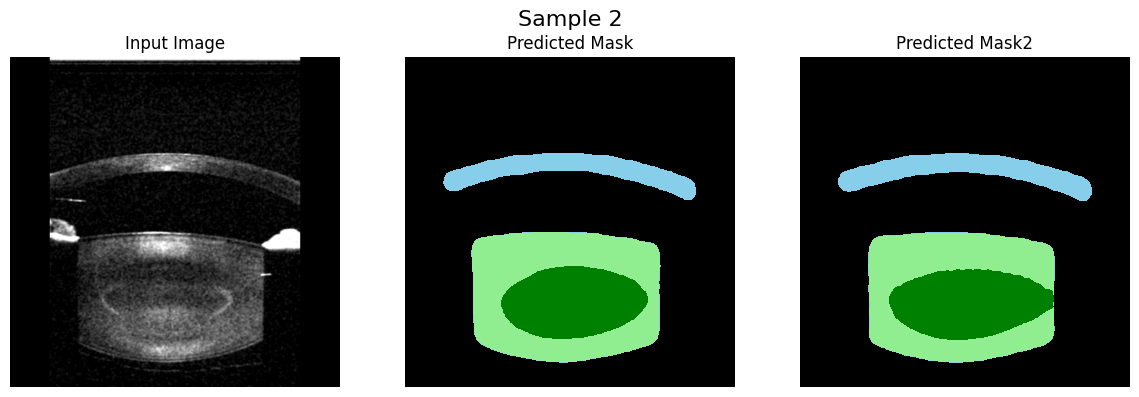

Sample 3: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


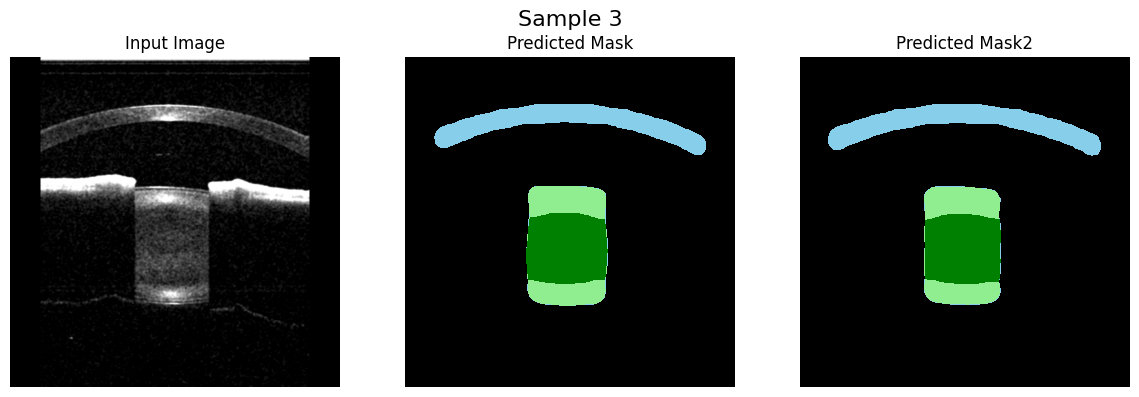

Sample 4: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


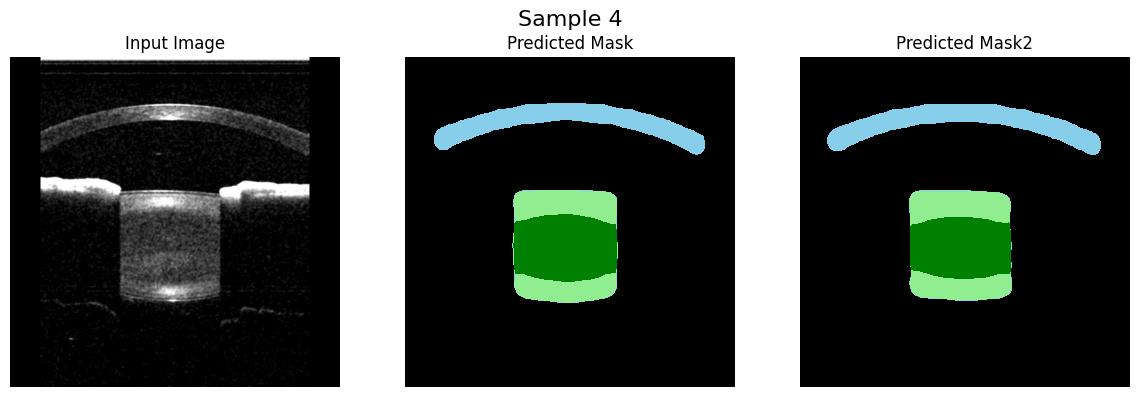

Sample 5: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


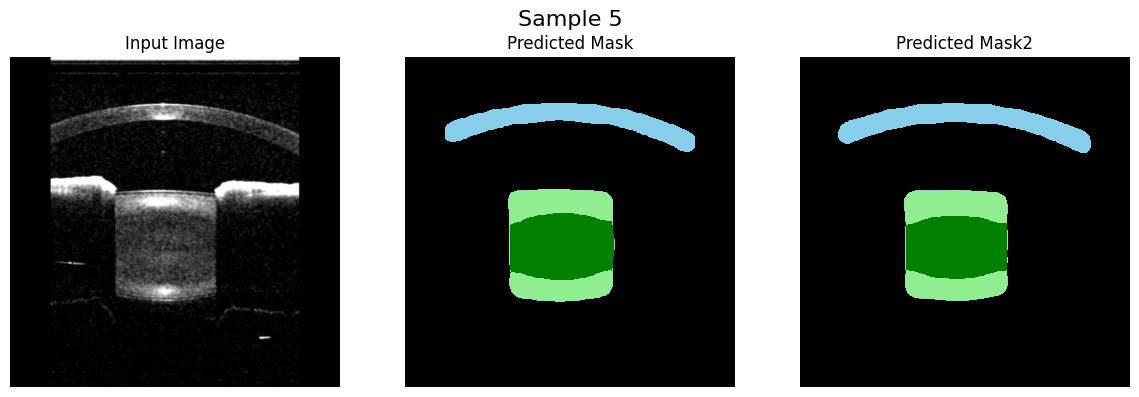

Sample 6: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


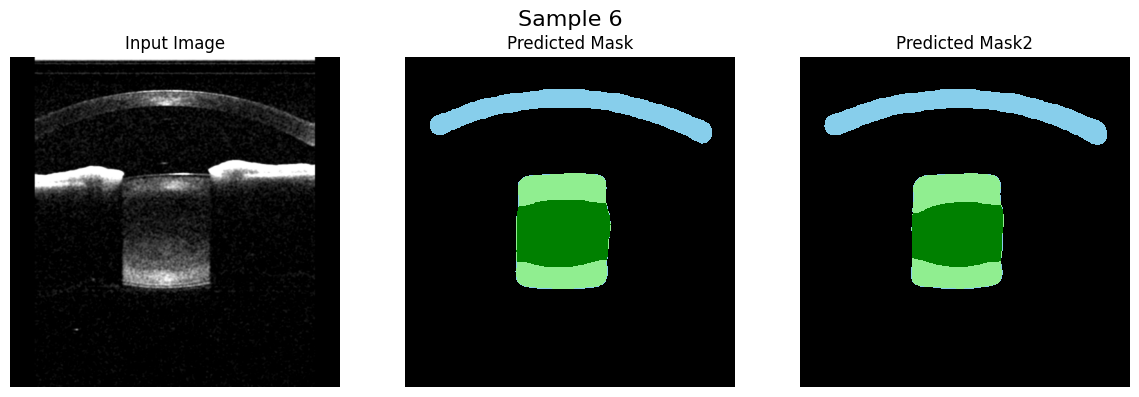

Sample 7: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


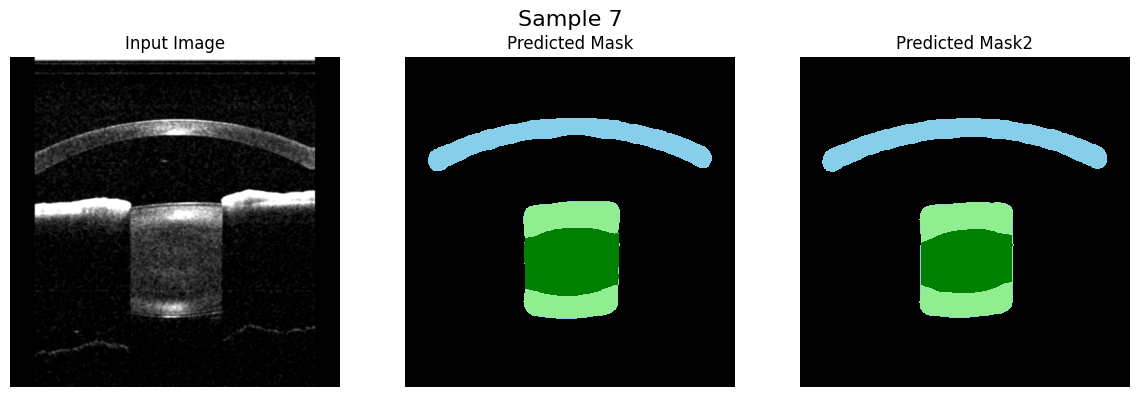

Sample 8: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


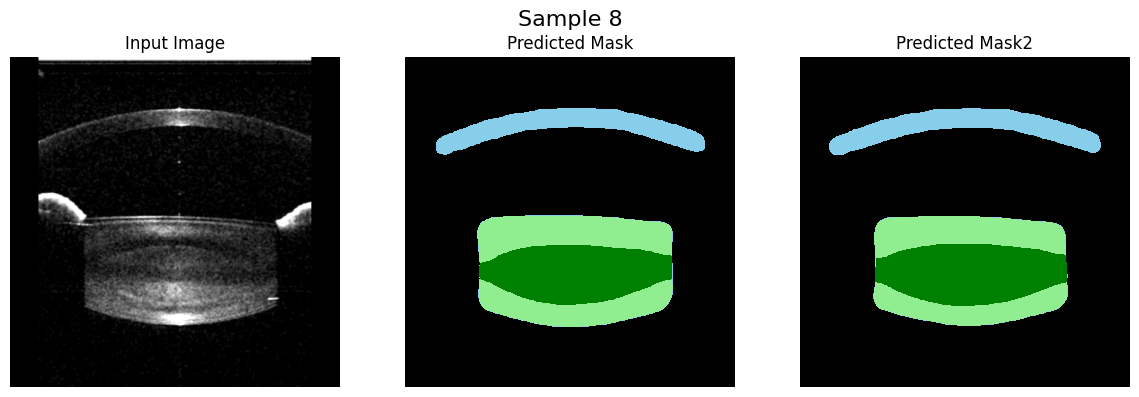

Sample 9: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


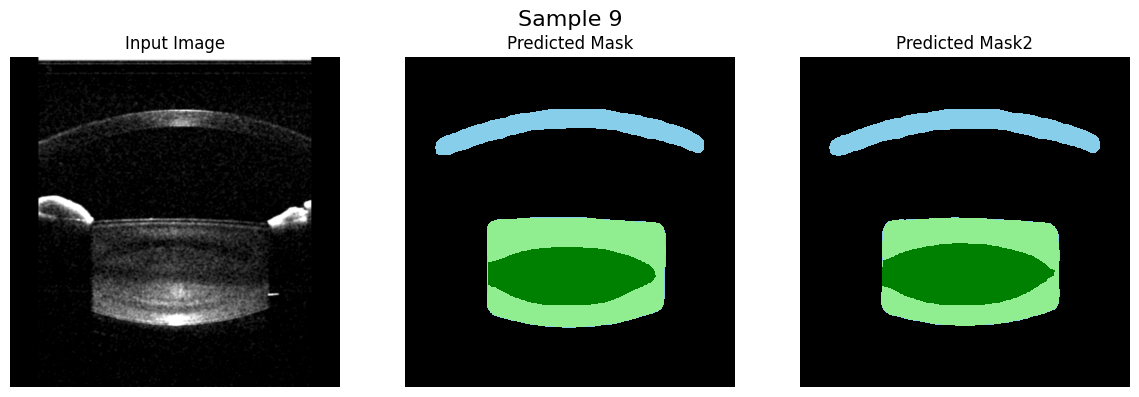

Sample 10: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


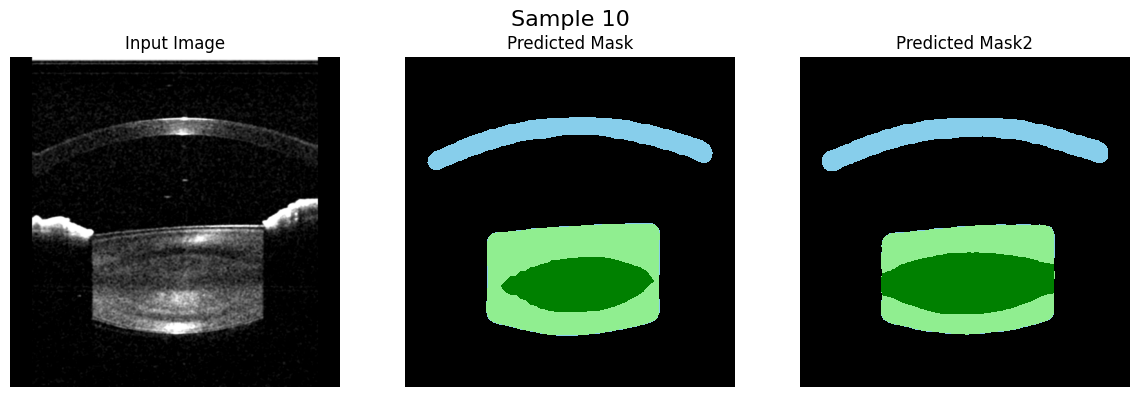

Sample 11: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


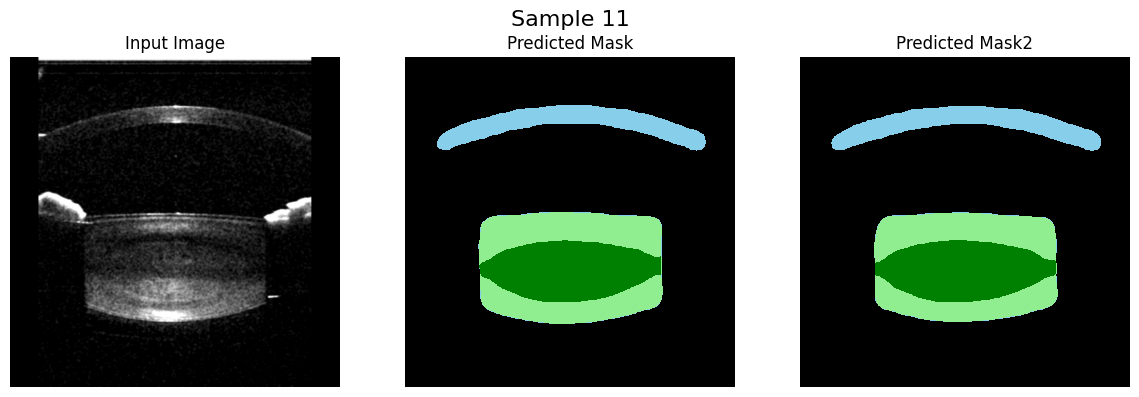

Sample 12: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


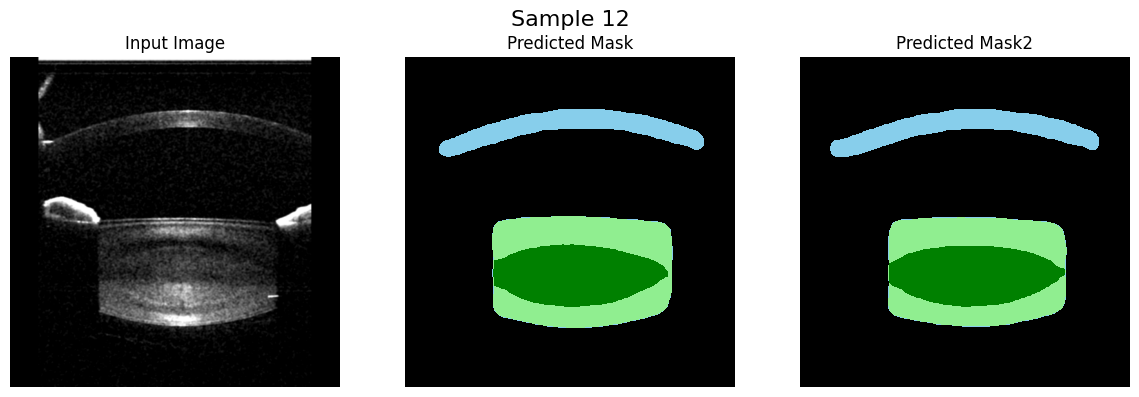

Sample 13: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


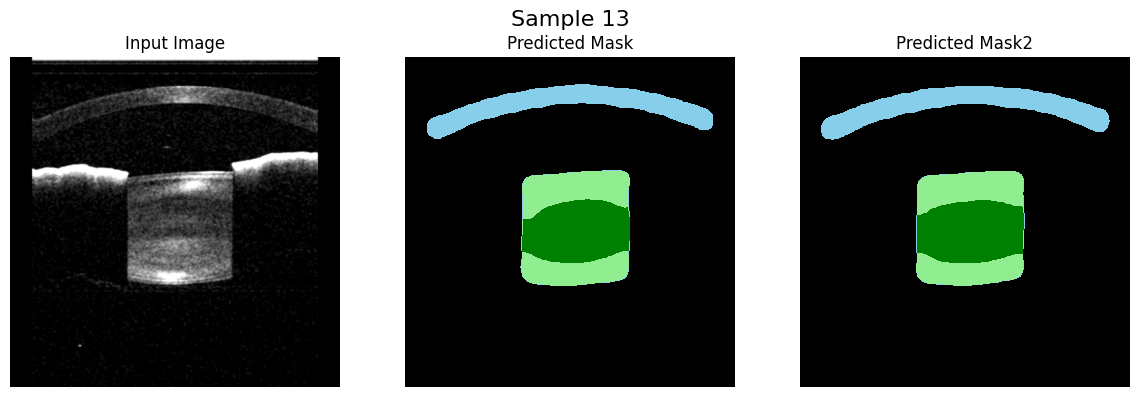

Sample 14: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


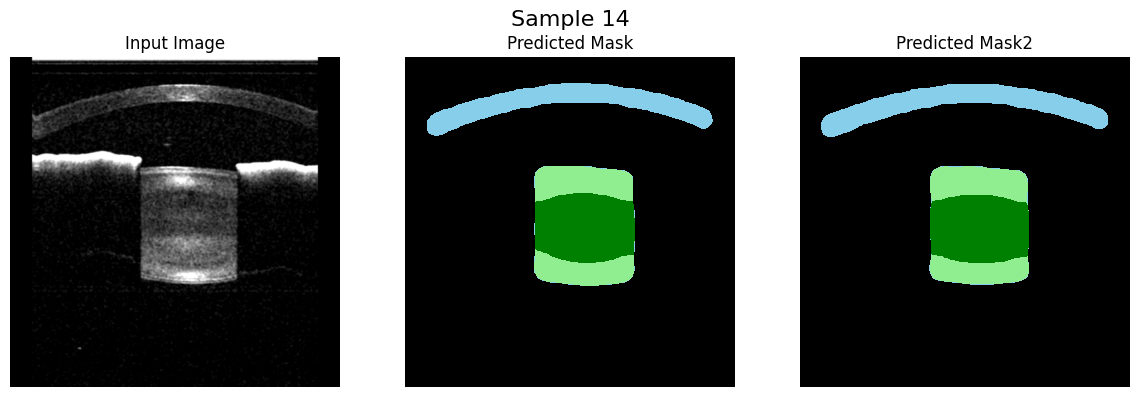

Sample 15: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


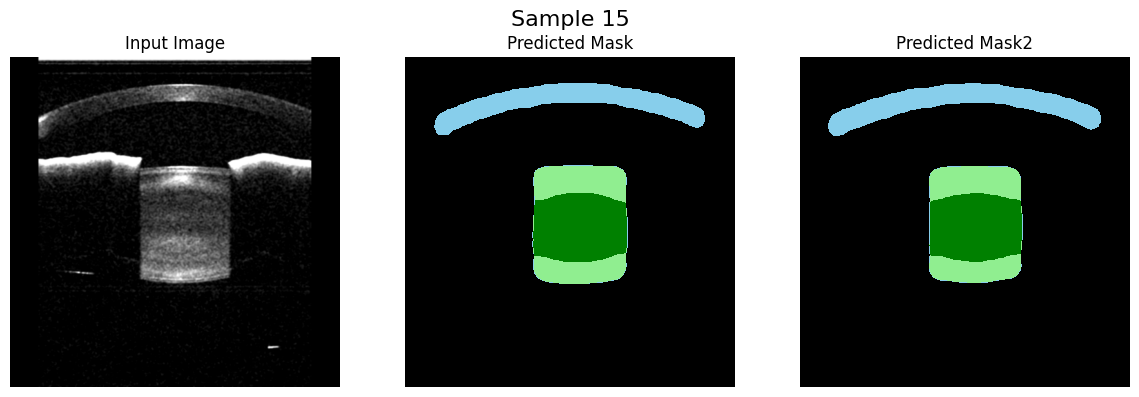

Sample 16: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


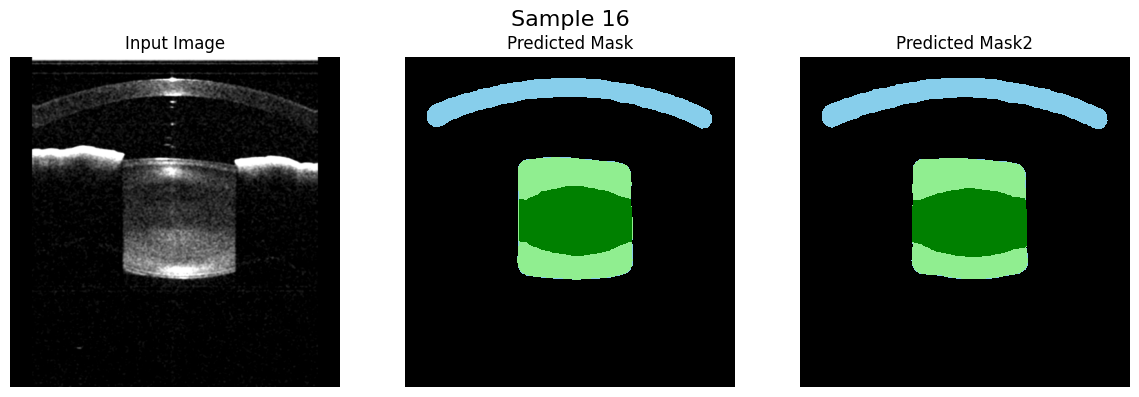

Sample 17: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


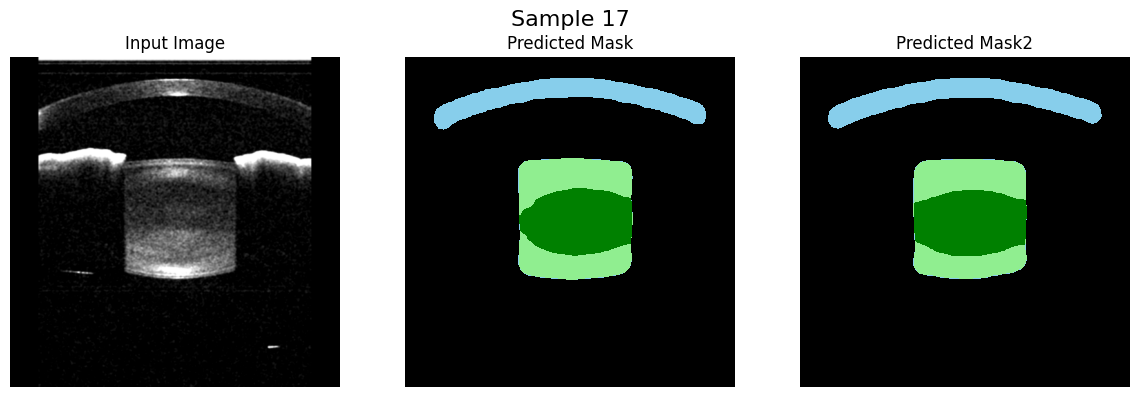

Sample 18: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


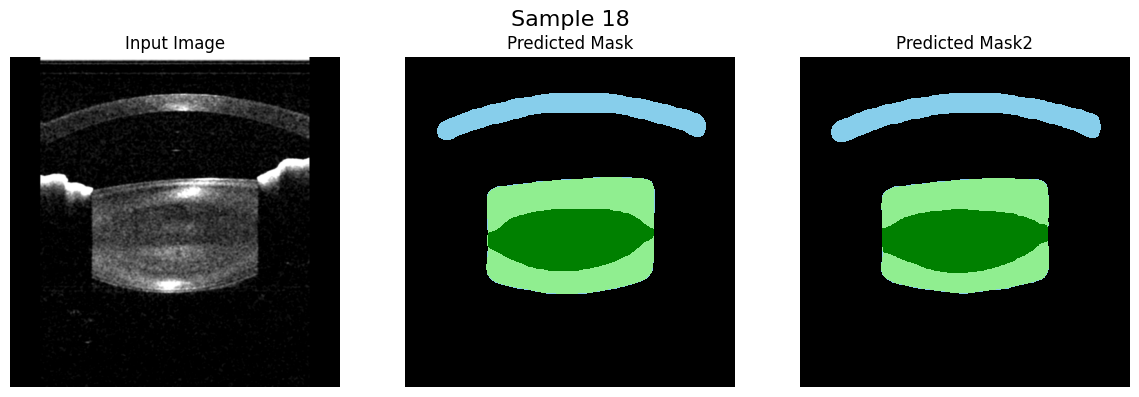

Sample 19: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


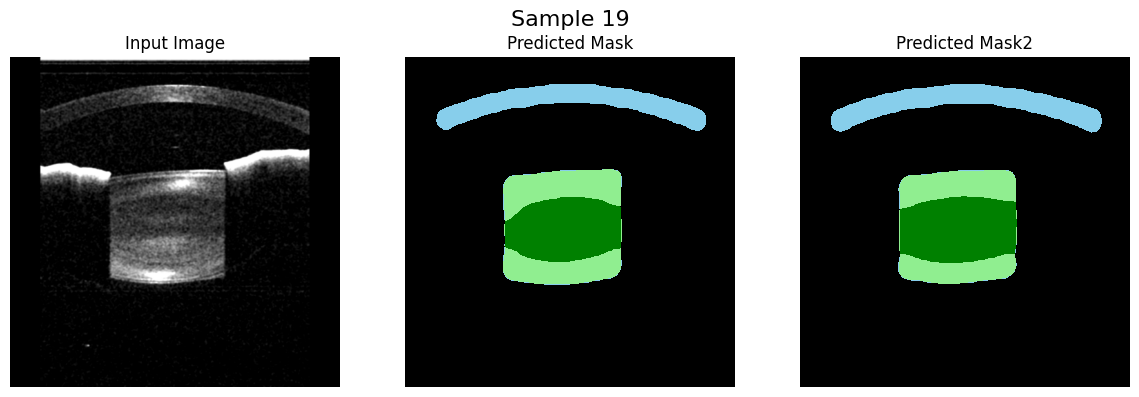

Sample 20: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


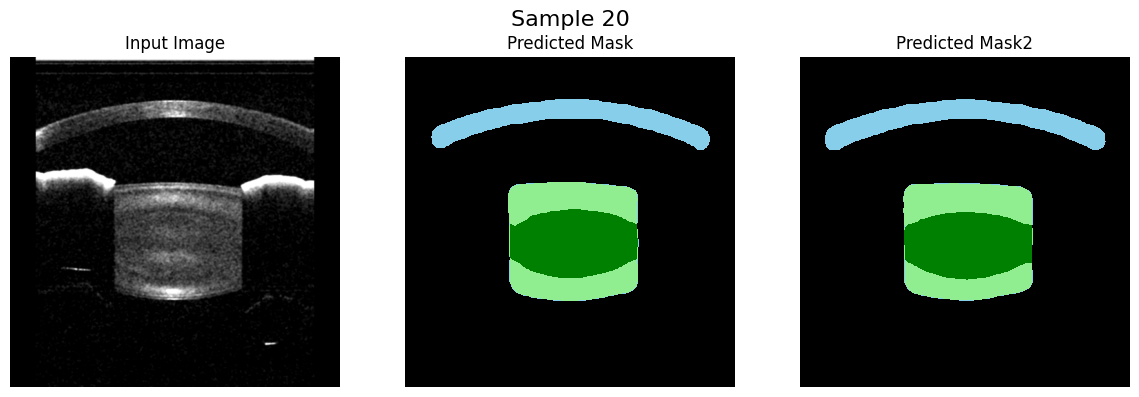

In [13]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from dataloader import OCTSegDataset
from torchvision import models, transforms
import torch.nn as nn
import numpy as np
from matplotlib.colors import ListedColormap

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_root = "/media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/dataset/cityscapes"  # change to your dataset folder
mean = [0.0918, 0.0918, 0.0918]
std = [0.1903, 0.1903, 0.1903]


colors = ['black', 'skyblue', 'lightgreen', 'green']
cmap = ListedColormap(colors)
class_names = ['', 'Cortex', 'Lense', 'Nucleus']

# Validation dataset
val_dataset = OCTSegDataset(root_dir=data_root, split="val")
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)

num_classes = 4
model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1,1))

model2 = models.segmentation.deeplabv3_resnet50(pretrained=True)
model2.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1,1))

# Load checkpoint
checkpoint_path = "checkpoints/deeplabv3_norm_fold4_best.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

checkpoint_path2 = "checkpoints/deeplabv3_keep_fold4_best.pth"
checkpoint2 = torch.load(checkpoint_path2, map_location=device)

# Depending on how you saved the model:
if "model_state" in checkpoint:
    model.load_state_dict(checkpoint["model_state"])
    model2.load_state_dict(checkpoint2["model_state"])
else:
    model.load_state_dict(checkpoint)
    model2.load_state_dict(checkpoint2)

model.to(device)
model2.to(device)

model.eval()
model2.eval()

with torch.no_grad():
    for images, targets in val_loader:
        images = images.to(device)
        targets = targets.to(device)
        outputs = model(images)['out']
        preds = torch.argmax(outputs, dim=1).cpu().numpy()  # [B,H,W]

        mean2 = torch.tensor([0.0918, 0.0918, 0.0918], device=images.device).view(1, 3, 1, 1)
        std2 = torch.tensor([0.1903, 0.1903, 0.1903], device=images.device).view(1, 3, 1, 1)
        images2 = (images - mean2) / std2
        outputs2 = model2(images2)['out']
        preds2 = torch.argmax(outputs2, dim=1).cpu().numpy()  # [B,H,W]
        
        images = images.cpu()
        targets = targets.cpu().numpy()

        batch_size = images.shape[0]

        # Plotting all predictions in the batch
        for i in range(batch_size):
            img = images[i]
            label = targets[i]
            pred = preds[i]
            pred2 = preds2[i]
            print(f"Sample {i+1}: Unique classes in label: {np.unique(label)}, in pred: {np.unique(pred)}, in pred2: {np.unique(pred2)}")

            # Denormalize for visualization
            img = img.numpy().transpose(1, 2, 0)  # from [C,H,W] to [H,W,C]
            # img = img * std + mean  # undo normalization
            # img = np.clip(img, 0, 1)

            plt.figure(figsize=(12, 4))
            plt.suptitle(f"Sample {i+1}", fontsize=16)

            plt.subplot(1, 3, 1)
            plt.imshow(img)
            plt.title("Input Image")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(pred, cmap=cmap, vmin=0, vmax=num_classes-1)
            plt.title("Predicted Mask")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            im = plt.imshow(pred2, cmap=cmap, vmin=0, vmax=3)
            # cbar = plt.colorbar(im, ticks=[0, 1, 2, 3])
            # cbar.ax.set_yticklabels(class_names)
            plt.title("Predicted Mask2")
            plt.axis("off")

            plt.tight_layout()
            plt.show()
        
        # Just plot the first batch
        break

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image

# -----------------------------
# 1. Setup
# -----------------------------

label_folder = "/media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/dataset/cityscapes/labels/train"
num_classes = 4

class_names = ['Background', 'Cortex', 'Lense', 'Nucleus']
colors = ['black', 'skyblue', 'lightgreen', 'green']
cmap = ListedColormap(colors)


all_class_ids = set()
label_files = sorted([f for f in os.listdir(label_folder) if f.endswith(('.png', '.jpg', '.npy'))])

# -----------------------------
# 2. Load + Analyze Labels
# -----------------------------
for idx, file in enumerate(label_files):
    path = os.path.join(label_folder, file)

    # Load label image
    if file.endswith('.npy'):
        label = np.load(path)
    else:
        label = np.array(Image.open(path))

    # Flatten and update global set of unique class ids
    unique = np.unique(label)
    all_class_ids.update(unique)

    print(f"[{idx+1}/{len(label_files)}] {file} → Unique classes: {unique}")
    unique, counts = np.unique(label, return_counts=True)
    
    class_pixel_counts = dict(zip(unique, counts))
    print(f"{file} → Pixel count per class: {class_pixel_counts}")


    # -----------------------------
    # 3. Plot Label with Colorbar
    # -----------------------------
    # plt.figure(figsize=(5, 4))
    # im = plt.imshow(label, cmap=cmap, vmin=0, vmax=num_classes - 1)
    # # cbar = plt.colorbar(im, ticks=range(num_classes))
    # # cbar.ax.set_yticklabels(class_names)
    # plt.title(f"Label: {file}")
    # plt.axis("off")
    # plt.tight_layout()
    # plt.show()

print(f"\n✅ Unique classes across all labels: {sorted(all_class_ids)}")


Sample 1: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


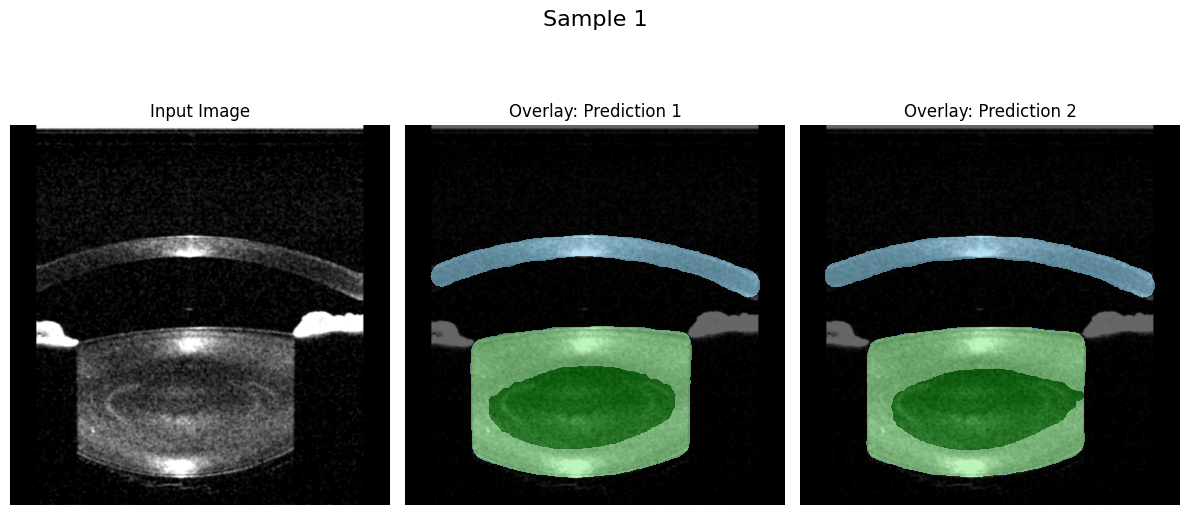

Area (pixels) per class for Sample 1:
  Class 0 (): 192675 pixels
  Class 1 (Cortex): 14273 pixels
  Class 2 (Lense): 33957 pixels
  Class 3 (Nucleus): 21239 pixels
Sample 2: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


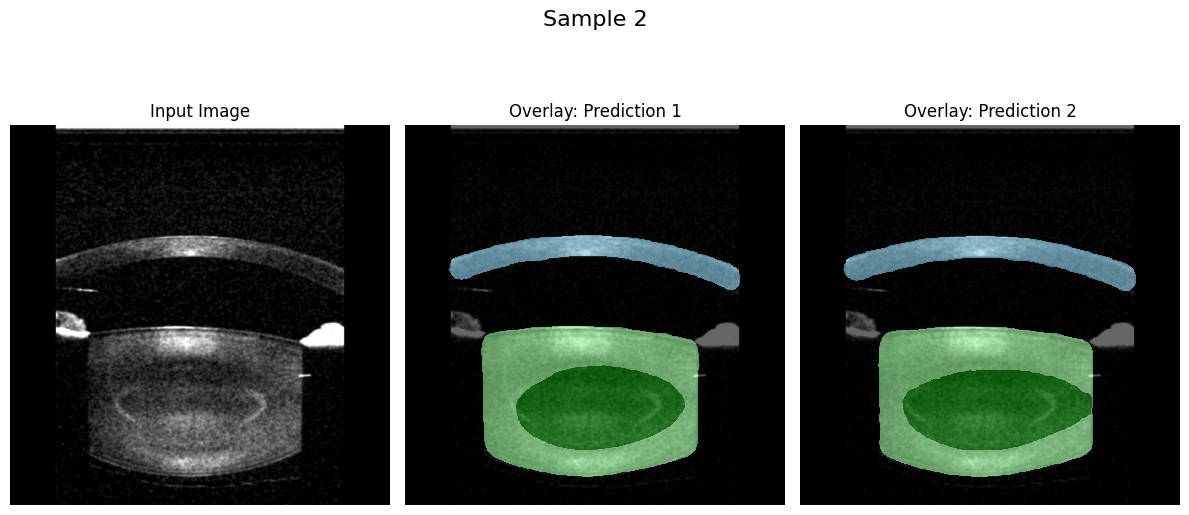

Area (pixels) per class for Sample 2:
  Class 0 (): 196306 pixels
  Class 1 (Cortex): 12202 pixels
  Class 2 (Lense): 34181 pixels
  Class 3 (Nucleus): 19455 pixels
Sample 3: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


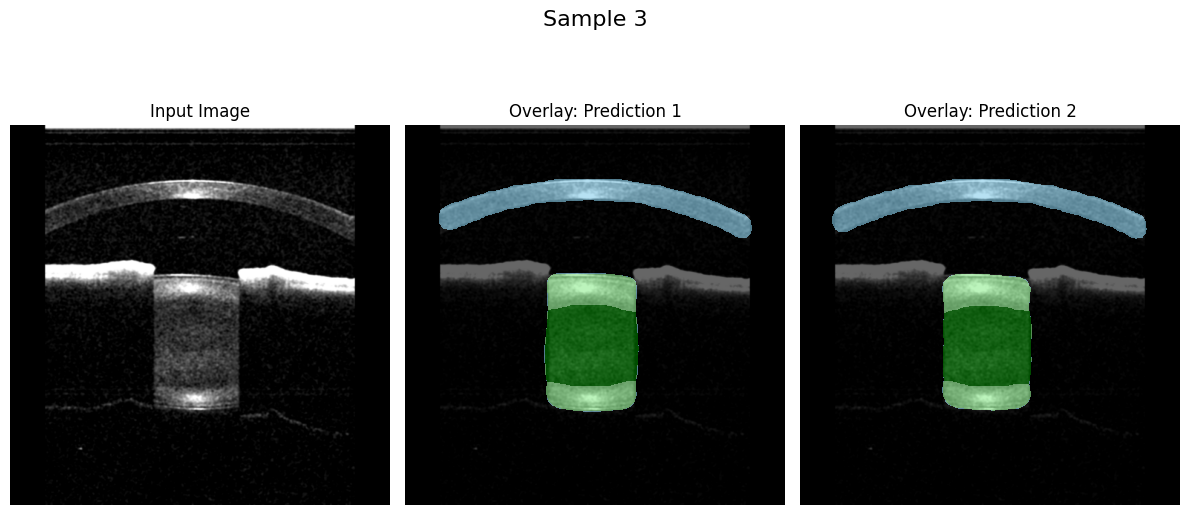

Area (pixels) per class for Sample 3:
  Class 0 (): 226740 pixels
  Class 1 (Cortex): 13283 pixels
  Class 2 (Lense): 9378 pixels
  Class 3 (Nucleus): 12743 pixels
Sample 4: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


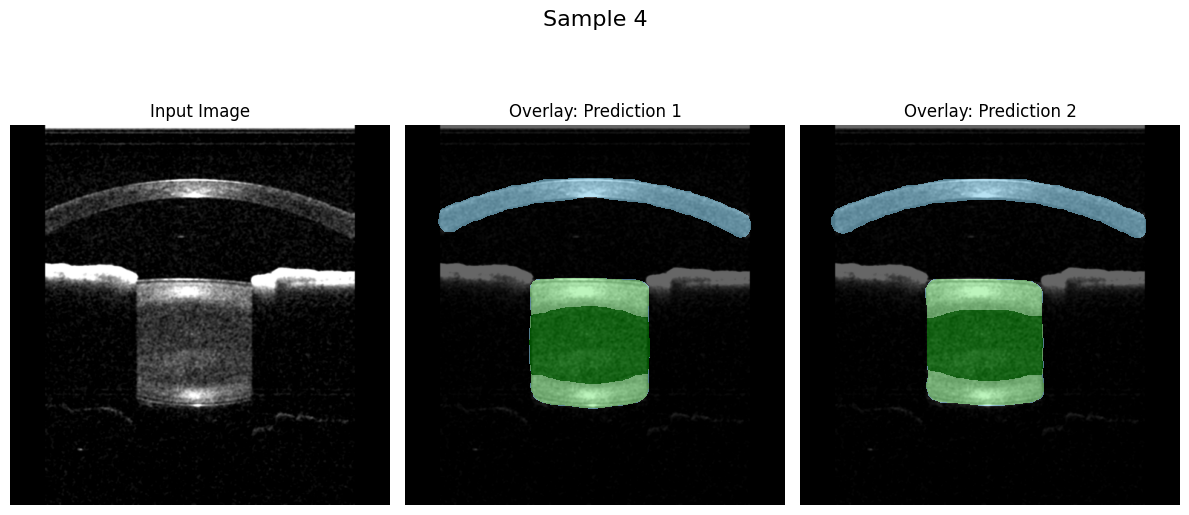

Area (pixels) per class for Sample 4:
  Class 0 (): 221698 pixels
  Class 1 (Cortex): 13360 pixels
  Class 2 (Lense): 12158 pixels
  Class 3 (Nucleus): 14928 pixels
Sample 5: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


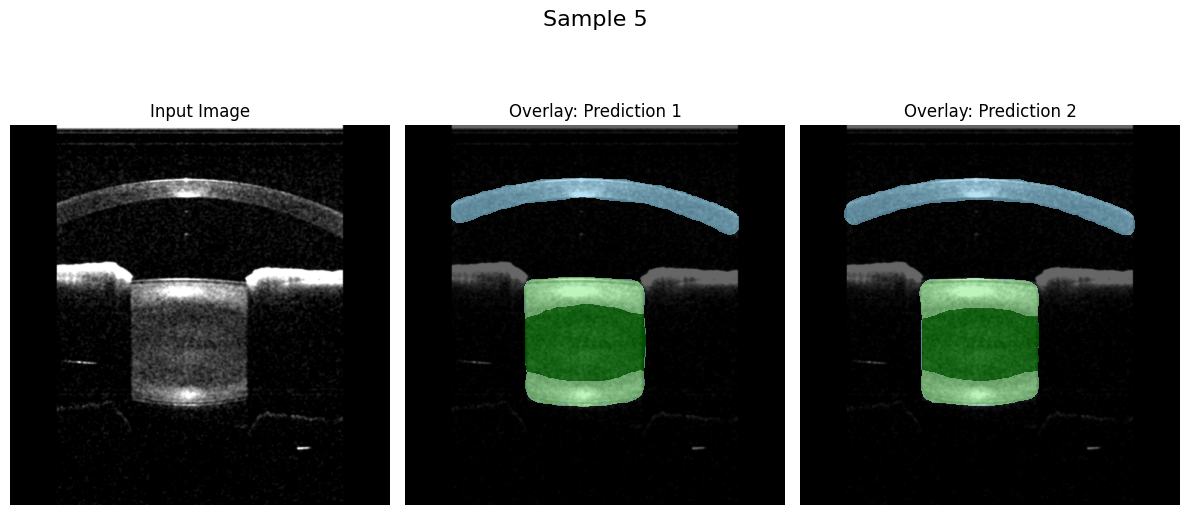

Area (pixels) per class for Sample 5:
  Class 0 (): 223008 pixels
  Class 1 (Cortex): 12037 pixels
  Class 2 (Lense): 12349 pixels
  Class 3 (Nucleus): 14750 pixels
Sample 6: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


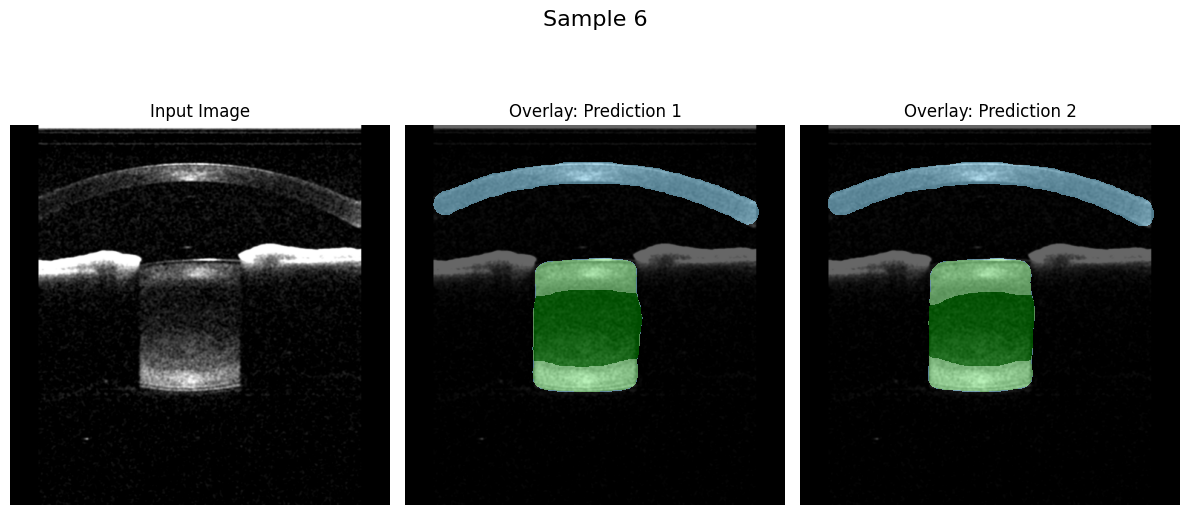

Area (pixels) per class for Sample 6:
  Class 0 (): 223783 pixels
  Class 1 (Cortex): 13697 pixels
  Class 2 (Lense): 10883 pixels
  Class 3 (Nucleus): 13781 pixels
Sample 7: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


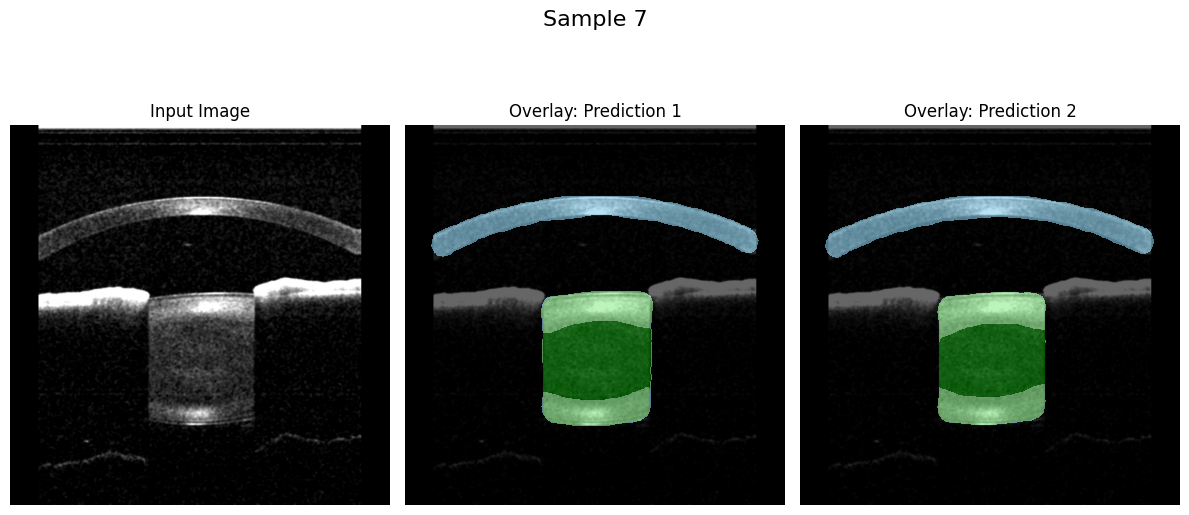

Area (pixels) per class for Sample 7:
  Class 0 (): 222483 pixels
  Class 1 (Cortex): 13940 pixels
  Class 2 (Lense): 11897 pixels
  Class 3 (Nucleus): 13824 pixels
Sample 8: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


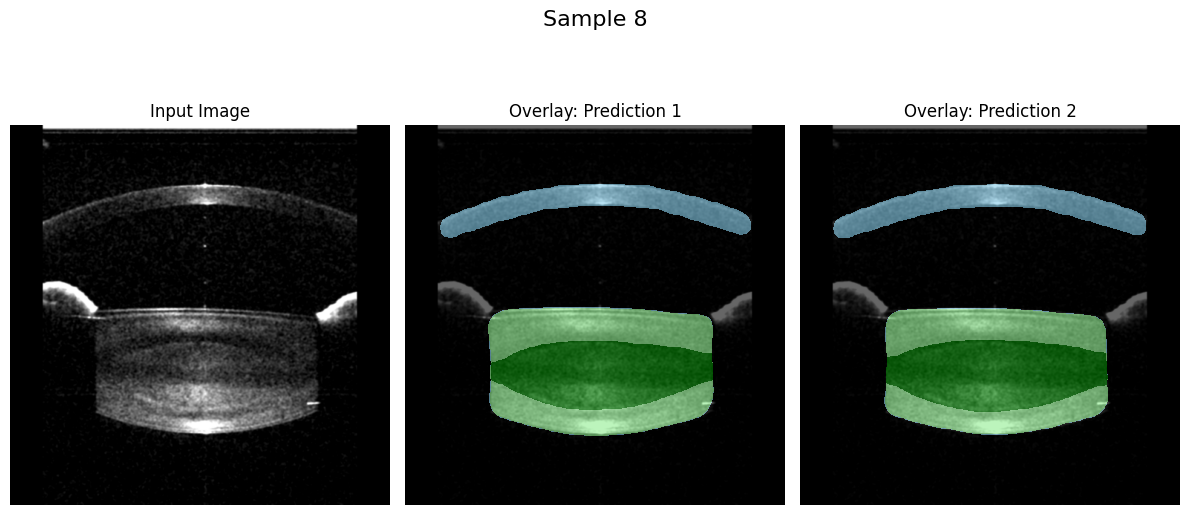

Area (pixels) per class for Sample 8:
  Class 0 (): 201507 pixels
  Class 1 (Cortex): 13165 pixels
  Class 2 (Lense): 26409 pixels
  Class 3 (Nucleus): 21063 pixels
Sample 9: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


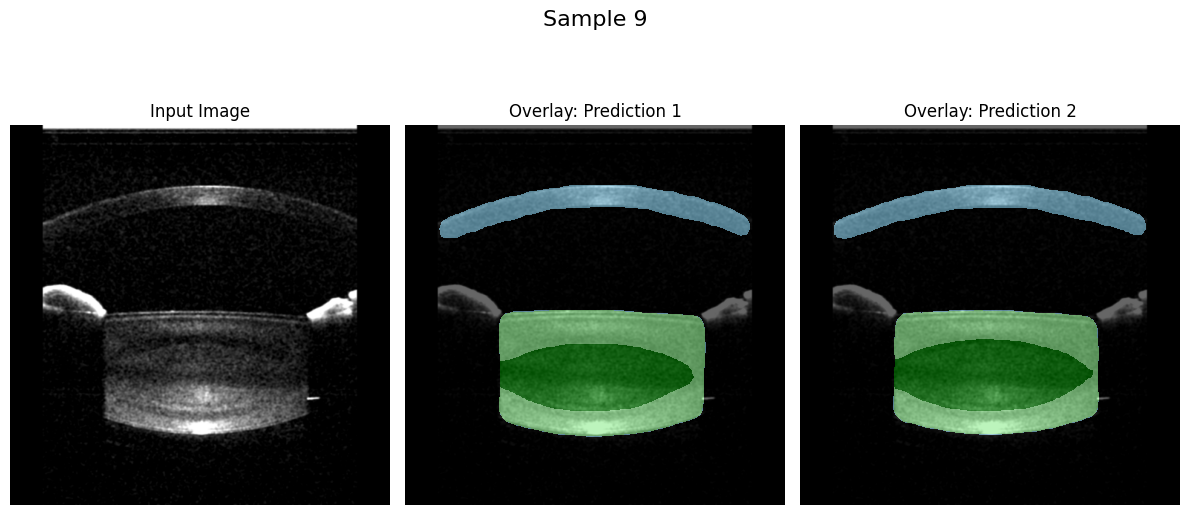

Area (pixels) per class for Sample 9:
  Class 0 (): 205238 pixels
  Class 1 (Cortex): 13058 pixels
  Class 2 (Lense): 25723 pixels
  Class 3 (Nucleus): 18125 pixels
Sample 10: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


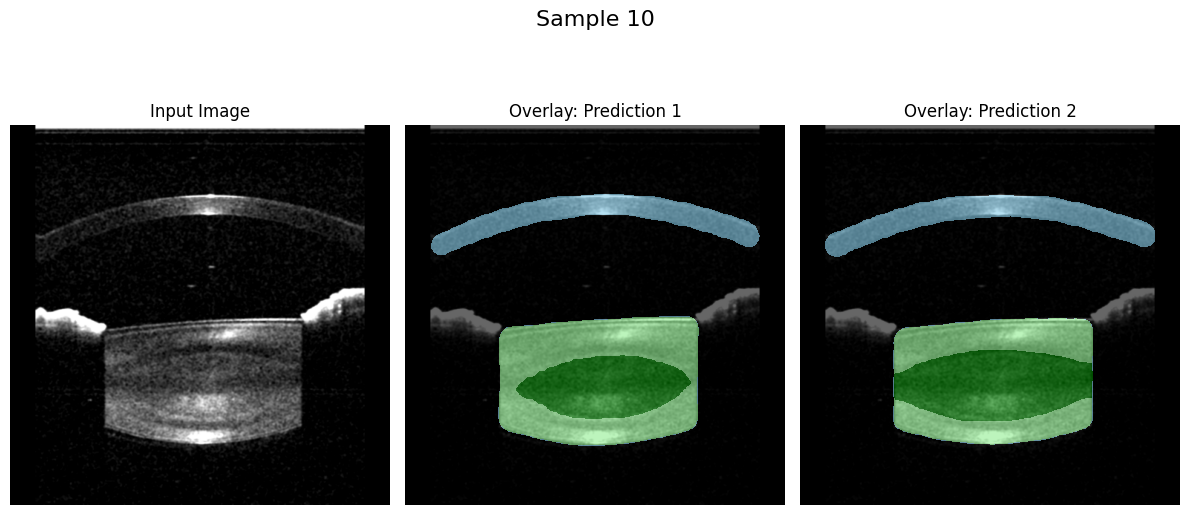

Area (pixels) per class for Sample 10:
  Class 0 (): 205604 pixels
  Class 1 (Cortex): 13783 pixels
  Class 2 (Lense): 28391 pixels
  Class 3 (Nucleus): 14366 pixels
Sample 11: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


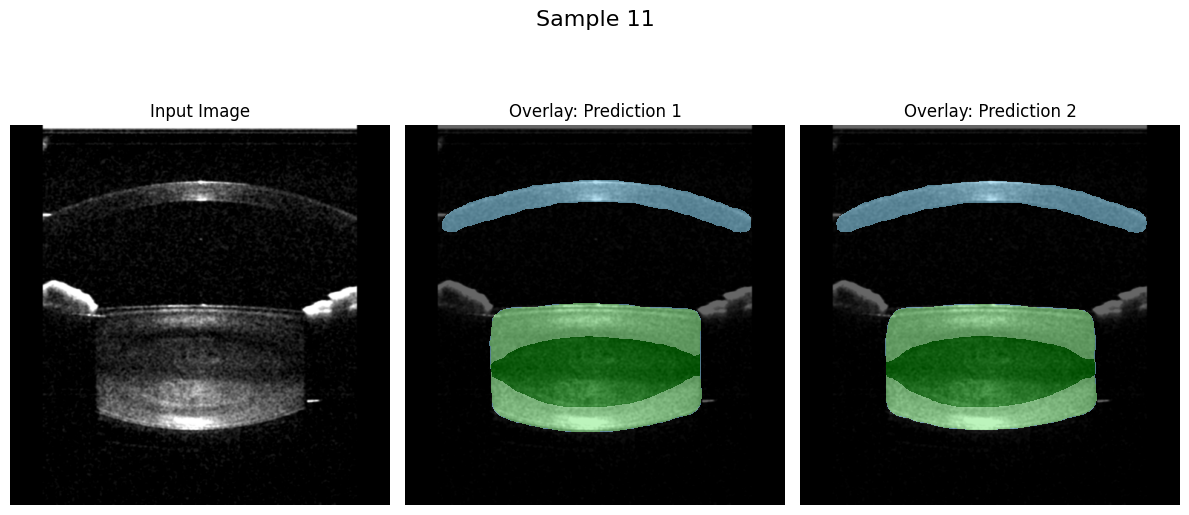

Area (pixels) per class for Sample 11:
  Class 0 (): 204245 pixels
  Class 1 (Cortex): 12762 pixels
  Class 2 (Lense): 25277 pixels
  Class 3 (Nucleus): 19860 pixels
Sample 12: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


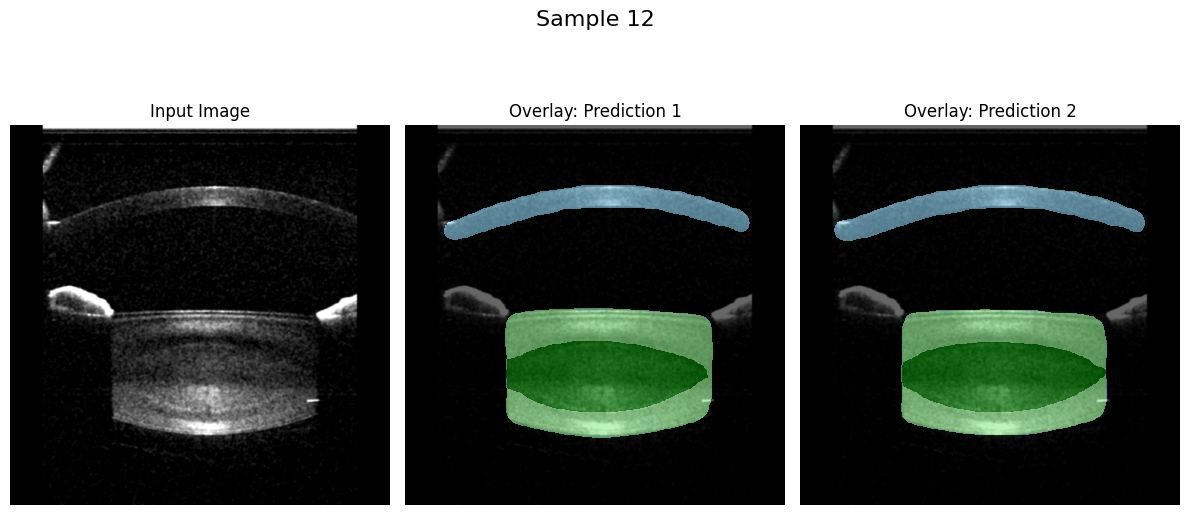

Area (pixels) per class for Sample 12:
  Class 0 (): 205059 pixels
  Class 1 (Cortex): 12602 pixels
  Class 2 (Lense): 24971 pixels
  Class 3 (Nucleus): 19512 pixels
Sample 13: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


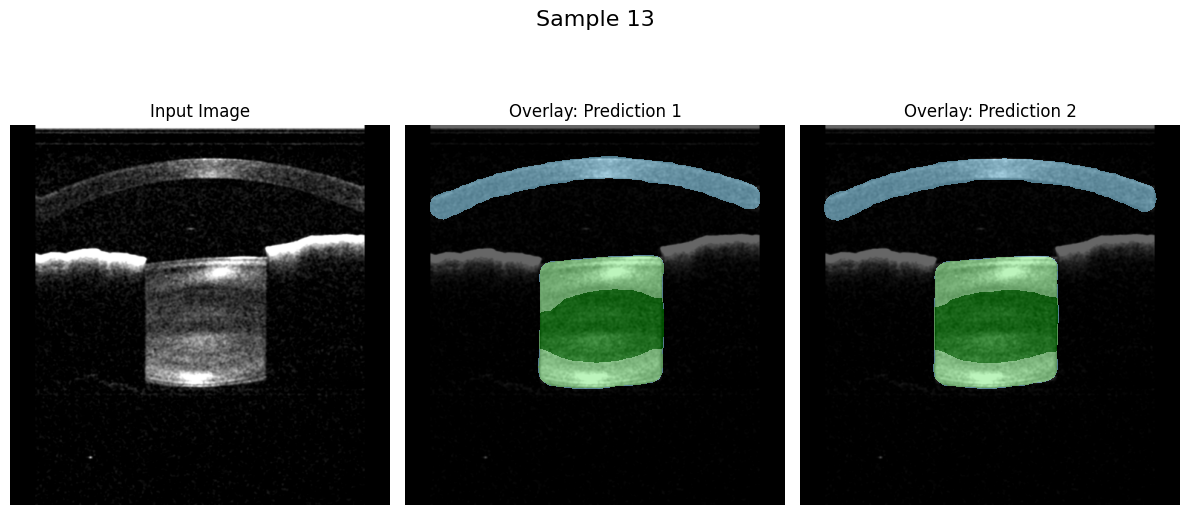

Area (pixels) per class for Sample 13:
  Class 0 (): 219371 pixels
  Class 1 (Cortex): 14176 pixels
  Class 2 (Lense): 14957 pixels
  Class 3 (Nucleus): 13640 pixels
Sample 14: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


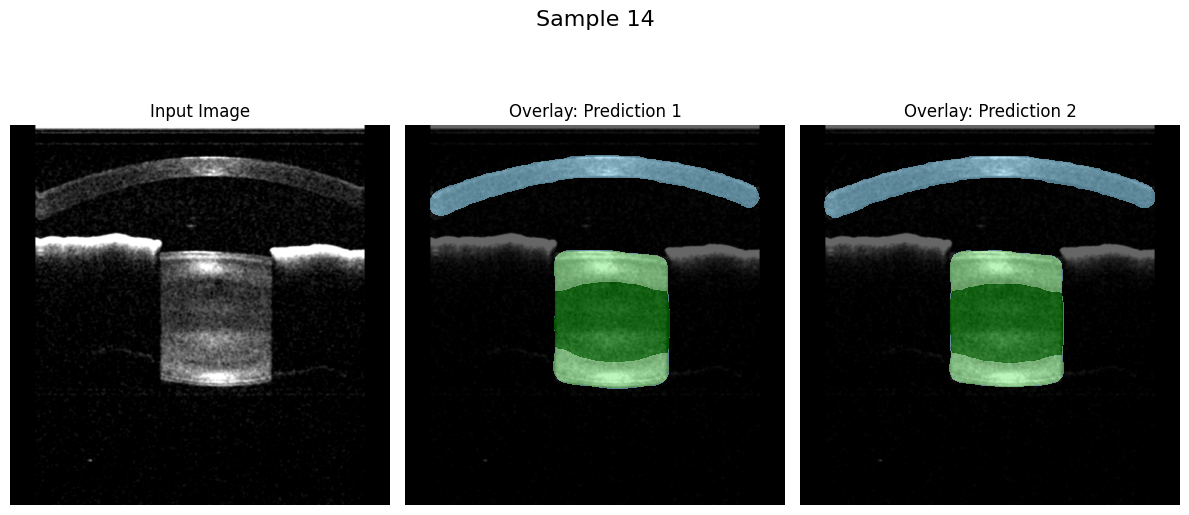

Area (pixels) per class for Sample 14:
  Class 0 (): 220324 pixels
  Class 1 (Cortex): 14263 pixels
  Class 2 (Lense): 12808 pixels
  Class 3 (Nucleus): 14749 pixels
Sample 15: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


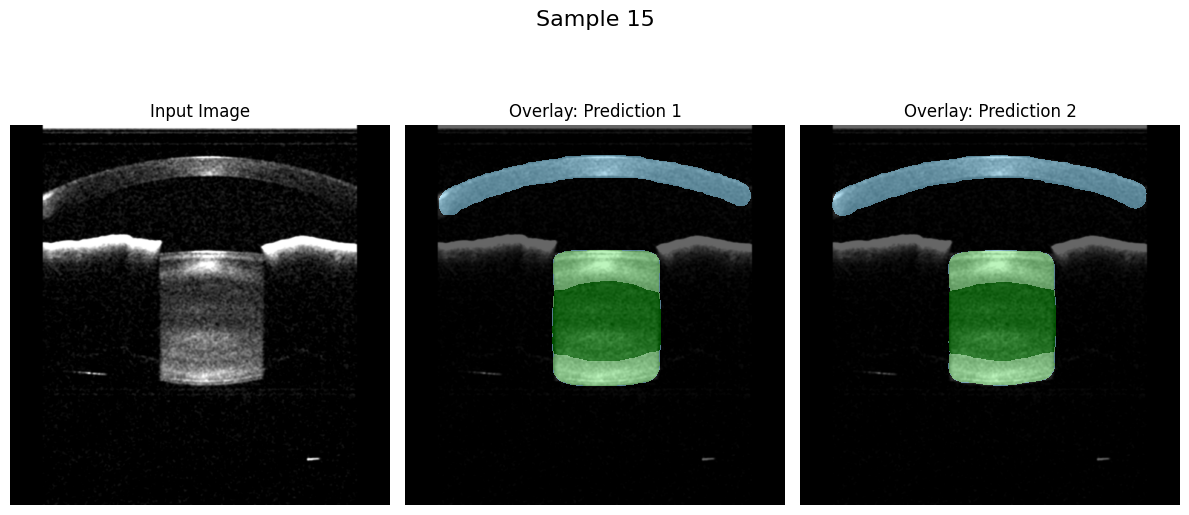

Area (pixels) per class for Sample 15:
  Class 0 (): 222693 pixels
  Class 1 (Cortex): 13647 pixels
  Class 2 (Lense): 11808 pixels
  Class 3 (Nucleus): 13996 pixels
Sample 16: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


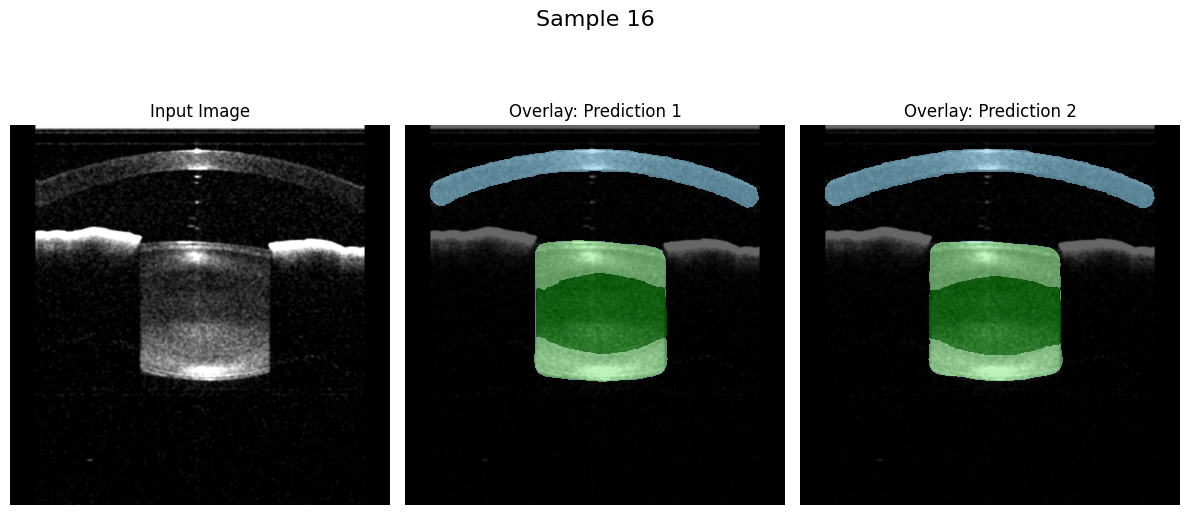

Area (pixels) per class for Sample 16:
  Class 0 (): 215881 pixels
  Class 1 (Cortex): 14146 pixels
  Class 2 (Lense): 16201 pixels
  Class 3 (Nucleus): 15916 pixels
Sample 17: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


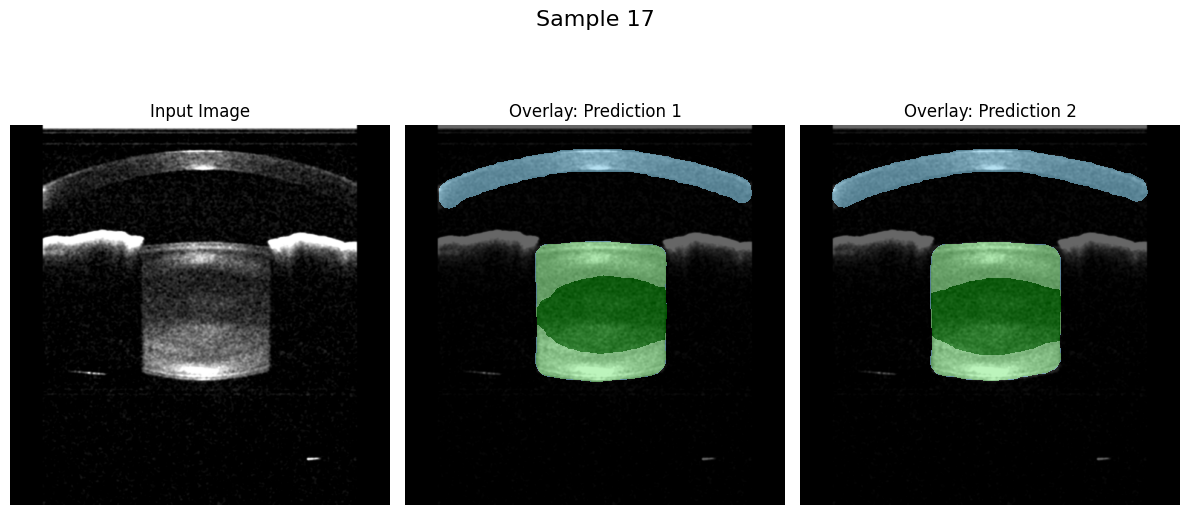

Area (pixels) per class for Sample 17:
  Class 0 (): 216726 pixels
  Class 1 (Cortex): 13709 pixels
  Class 2 (Lense): 16927 pixels
  Class 3 (Nucleus): 14782 pixels
Sample 18: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


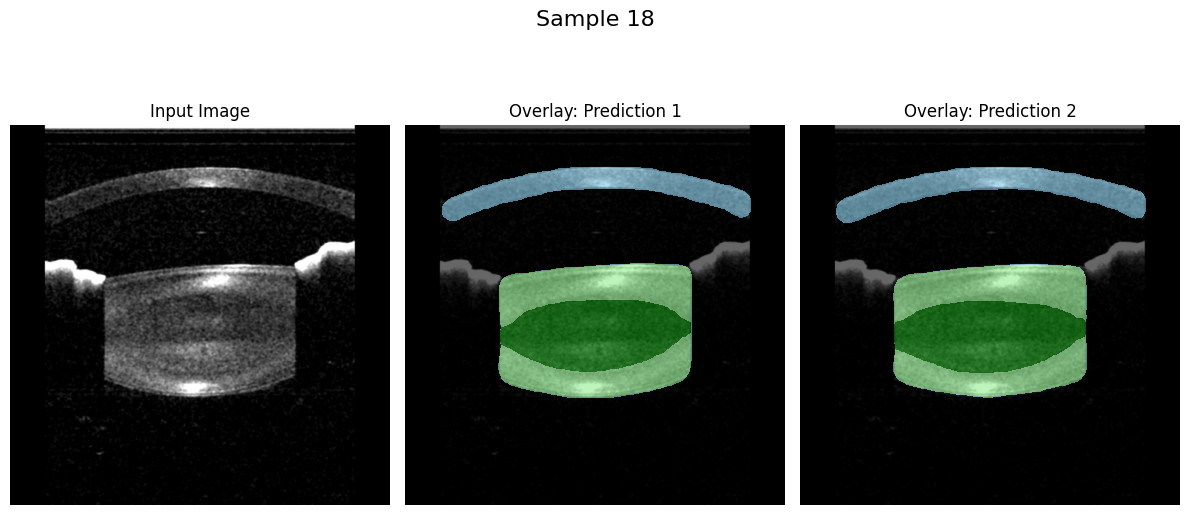

Area (pixels) per class for Sample 18:
  Class 0 (): 205553 pixels
  Class 1 (Cortex): 13379 pixels
  Class 2 (Lense): 24661 pixels
  Class 3 (Nucleus): 18551 pixels
Sample 19: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


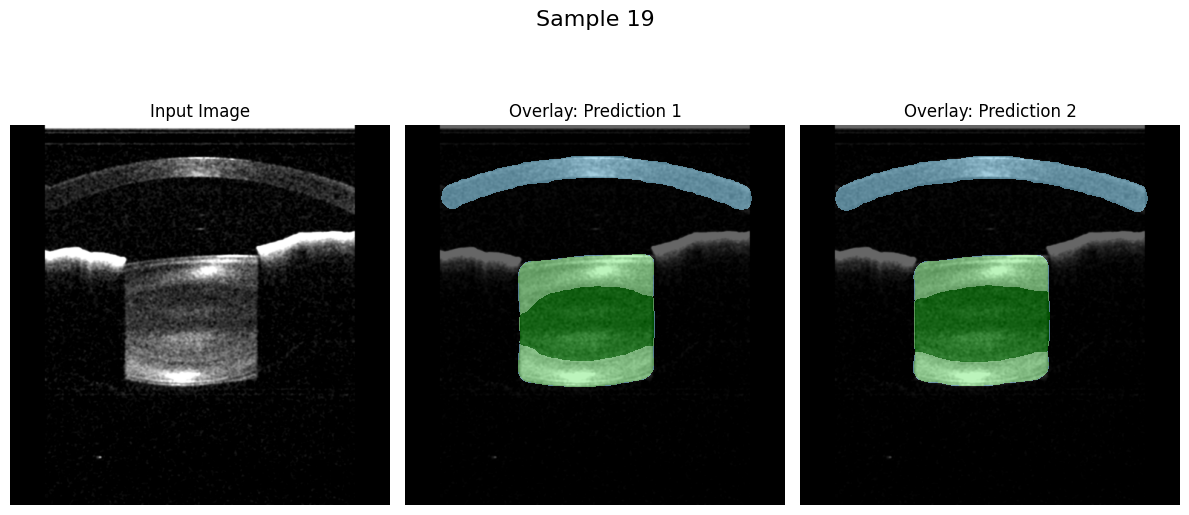

Area (pixels) per class for Sample 19:
  Class 0 (): 217776 pixels
  Class 1 (Cortex): 13347 pixels
  Class 2 (Lense): 16004 pixels
  Class 3 (Nucleus): 15017 pixels
Sample 20: Unique classes in label: [0 1 2 3], in pred: [0 1 2 3], in pred2: [0 1 2 3]


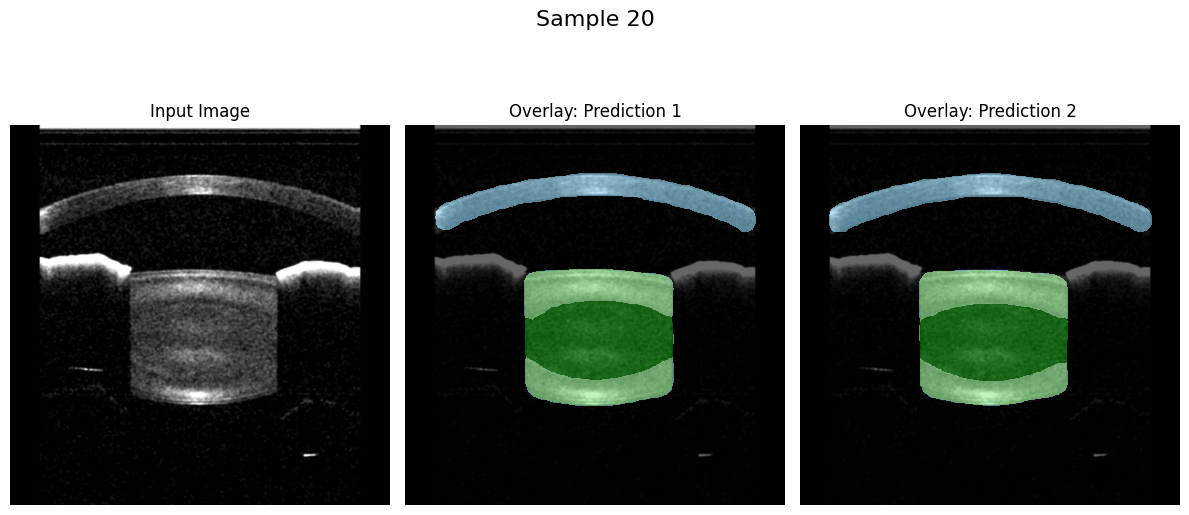

Area (pixels) per class for Sample 20:
  Class 0 (): 213223 pixels
  Class 1 (Cortex): 13915 pixels
  Class 2 (Lense): 17685 pixels
  Class 3 (Nucleus): 17321 pixels


In [17]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from dataloader import OCTSegDataset
from torchvision import models, transforms
import torch.nn as nn
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib import cm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_root = "/media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/dataset/cityscapes"  # change to your dataset folder
mean = [0.0918, 0.0918, 0.0918]
std = [0.1903, 0.1903, 0.1903]


colors = ['black', 'skyblue', 'lightgreen', 'green']
cmap = ListedColormap(colors)
class_names = ['', 'Cortex', 'Lense', 'Nucleus']

# Validation dataset
val_dataset = OCTSegDataset(root_dir=data_root, split="val")
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)

num_classes = 4
model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1,1))

model2 = models.segmentation.deeplabv3_resnet50(pretrained=True)
model2.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1,1))

# Load checkpoint
checkpoint_path = "checkpoints/deeplabv3_norm_fold4_best.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

checkpoint_path2 = "checkpoints/deeplabv3_keep_fold4_best.pth"
checkpoint2 = torch.load(checkpoint_path2, map_location=device)

# Depending on how you saved the model:
if "model_state" in checkpoint:
    model.load_state_dict(checkpoint["model_state"])
    model2.load_state_dict(checkpoint2["model_state"])
else:
    model.load_state_dict(checkpoint)
    model2.load_state_dict(checkpoint2)

model.to(device)
model2.to(device)

model.eval()
model2.eval()

with torch.no_grad():
    for images, targets in val_loader:
        images = images.to(device)
        targets = targets.to(device)
        outputs = model(images)['out']
        preds = torch.argmax(outputs, dim=1).cpu().numpy()  # [B,H,W]

        mean2 = torch.tensor([0.0918, 0.0918, 0.0918], device=images.device).view(1, 3, 1, 1)
        std2 = torch.tensor([0.1903, 0.1903, 0.1903], device=images.device).view(1, 3, 1, 1)
        images2 = (images - mean2) / std2
        outputs2 = model2(images2)['out']
        preds2 = torch.argmax(outputs2, dim=1).cpu().numpy()  # [B,H,W]
        
        images = images.cpu()
        targets = targets.cpu().numpy()

        batch_size = images.shape[0]

        # Plotting all predictions in the batch
        for i in range(batch_size):
            img = images[i]
            label = targets[i]
            pred = preds[i]
            pred2 = preds2[i]
            print(f"Sample {i+1}: Unique classes in label: {np.unique(label)}, in pred: {np.unique(pred)}, in pred2: {np.unique(pred2)}")

            # Denormalize for visualization
            img = img.numpy().transpose(1, 2, 0)  # from [C,H,W] to [H,W,C]
            # img = img * std + mean  # undo normalization
            # img = np.clip(img, 0, 1)

            plt.figure(figsize=(12, 6))
            plt.suptitle(f"Sample {i+1}", fontsize=16)

            # --- 1. Original Image ---
            plt.subplot(1, 3, 1)
            plt.imshow(img)
            plt.title("Input Image")
            plt.axis("off")

            # --- 2. Overlay Prediction (Model 1) ---
            plt.subplot(1, 3, 2)
            plt.imshow(img)  # Base image
            plt.imshow(pred, cmap=cmap, alpha=0.6, vmin=0, vmax=num_classes-1)  # Overlay
            plt.title("Overlay: Prediction 1")
            plt.axis("off")

            # --- 3. Overlay Prediction (Model 2) ---
            plt.subplot(1, 3, 3)
            plt.imshow(img)
            plt.imshow(pred2, cmap=cmap, alpha=0.6, vmin=0, vmax=num_classes-1)
            plt.title("Overlay: Prediction 2")
            plt.axis("off")

            plt.tight_layout()
            plt.show()

            unique_classes, counts = np.unique(pred, return_counts=True)
            area_per_class = dict(zip(unique_classes, counts))
            print(f'Area (pixels) per class for Sample {i+1}:')
            for cls_id in range(num_classes):
                area = area_per_class.get(cls_id, 0)
                print(f'  Class {cls_id} ({class_names[cls_id]}): {area} pixels')

        
        # Just plot the first batch
        break

In [ ]:
# demo.py

import torch
import torchvision.utils as vutils
import numpy as np
import torchvision.models as models
from torchvision import datasets
from tensorboardX import SummaryWriter


resnet18 = models.resnet18(False)
writer = SummaryWriter()
sample_rate = 44100
freqs = [262, 294, 330, 349, 392, 440, 440, 440, 440, 440, 440]

for n_iter in range(100):

    dummy_s1 = torch.rand(1)
    dummy_s2 = torch.rand(1)
    # data grouping by `slash`
    writer.add_scalar('data/scalar1', dummy_s1[0], n_iter)
    writer.add_scalar('data/scalar2', dummy_s2[0], n_iter)

    writer.add_scalars('data/scalar_group', {'xsinx': n_iter * np.sin(n_iter),
                                             'xcosx': n_iter * np.cos(n_iter),
                                             'arctanx': np.arctan(n_iter)}, n_iter)

    dummy_img = torch.rand(32, 3, 64, 64)  # output from network
    if n_iter % 10 == 0:
        x = vutils.make_grid(dummy_img, normalize=True, scale_each=True)
        writer.add_image('Image', x, n_iter)

        dummy_audio = torch.zeros(sample_rate * 2)
        for i in range(x.size(0)):
            # amplitude of sound should in [-1, 1]
            dummy_audio[i] = np.cos(freqs[n_iter // 10] * np.pi * float(i) / float(sample_rate))
        writer.add_audio('myAudio', dummy_audio, n_iter, sample_rate=sample_rate)

        writer.add_text('Text', 'text logged at step:' + str(n_iter), n_iter)

        for name, param in resnet18.named_parameters():
            writer.add_histogram(name, param.clone().cpu().data.numpy(), n_iter)

        # needs tensorboard 0.4RC or later
        writer.add_pr_curve('xoxo', np.random.randint(2, size=100), np.random.rand(100), n_iter)

dataset = datasets.MNIST('mnist', train=False, download=True)
images = dataset.test_data[:100].float()
label = dataset.test_labels[:100]

features = images.view(100, 784)
writer.add_embedding(features, metadata=label, label_img=images.unsqueeze(1))

# export scalar data to JSON for external processing
writer.export_scalars_to_json("./all_scalars.json")
writer.close()